# Сверточный слой нейросети

В PyTorch есть класс `nn.Conv2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), который реализует операцию свертки для целого изображения.


In [ ]:
import torch
import numpy as np

# fmt: off
cross = np.array([[0, 0 ,0, 0, 0],
                  [0, 0, 0, 0, 0],
                  [0, 0, 0, 1, 0],
                  [0, 0, 1, 1, 1],
                  [0, 0, 0, 1, 0]])

kernel_cs = np.array([[-1, 1, -1],
                      [ 1, 1,  1],
                      [-1, 1, -1]])
# fmt: on

cross_in_tensor = torch.tensor(cross).float()

In [ ]:
from torch.nn import Conv2d

conv = Conv2d(
    in_channels=1,  # what's this ?
    out_channels=1,  # what's this ?
    kernel_size=(3, 3),  # kernel.shape == 3x3
    bias=False,
)
# conv2d accepts input of shape BxCxHxW
feature_map = conv(
    cross_in_tensor.unsqueeze(0).unsqueeze(0)
)  # add batch and channel dim
print(feature_map)

tensor([[[[ 0.0000,  0.0020, -0.1460],
          [ 0.0020, -0.1745,  0.2456],
          [-0.0304,  0.3700,  0.1317]]]], grad_fn=<ConvolutionBackward0>)


Так как изначально ядро нашего единственного фильтра (нейрона) инициализированно случайными небольшими значениями, то на выходе получается набор ничего не значащих чисел. Убедимся, что слой работает так, как мы ожидали, подменив ядро:

In [ ]:
# data[0] because filter can have multiple kernels. see next chapter
conv.weight.data[0] = torch.tensor(kernel_cs)  # replace original kernel

feature_map = conv(
    cross_in_tensor.unsqueeze(0).unsqueeze(0)
)  # add batch and channel dim
print("Feature map for cross\n", feature_map)

Feature map for cross
 tensor([[[[ 0., -1.,  1.],
          [-1.,  1.,  0.],
          [ 1.,  0.,  5.]]]], grad_fn=<ConvolutionBackward0>)


При создании экземпляра объекта класса `nn.Conv2D` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) помимо размера ядра (`kernel_size`) мы передали в конструктор еще два параметра:

`in_channels = 1 ` и `out_channels = 1`

Разберемся, что они означают.

## Обработка цветных/многоканальных изображений

`in_channel` — это количество каналов входного тензора (изображения).

В примерах выше мы рассматривали [черно-белые 📚[wiki]](https://ru.wikipedia.org/wiki/Чёрно-белая_фотография) изображения. Их также называют одноканальными изображениями, т. к. в них цвет пикселя определяется одним числом, характеризующим яркость.

Хранятся они в двумерном массиве размером $[H,W]$. Цветные изображения хранятся в трехмерных массивах $[H,W,C]$ (для формата numpy, OpenCV) или $[C,W,H]$ (тензорный формат PyTorch), где $C$ — количество цветовых каналов. Для $\text{RGB}$-изображений $C=3$. Так как `Conv2d` рассчитан на работу с многоканальным входом, то в коде выше нам пришлось написать дополнительный `unsqueeze(0)`, чтобы добавить к тензору с изображением это $3$-е измерение, т. е. перевести $[H,W]$ в $[C,W,H]$, где $C = 1$.

Важно, что для каждого канала будет создано дополнительное ядро фильтра.

In [ ]:
conv_ch1 = Conv2d(in_channels=1, out_channels=1, kernel_size=5)
print("One channel kernel \t", conv_ch1.weight.shape)
conv_ch3 = Conv2d(in_channels=3, out_channels=1, kernel_size=5)
print("Three channel kernel \t", conv_ch3.weight.shape)

One channel kernel 	 torch.Size([1, 1, 5, 5])
Three channel kernel 	 torch.Size([1, 3, 5, 5])


Опробуем трехканальную свертку на цветном изображении:

In [ ]:
!wget -q https://ml.gan4x4.ru/msu/dev-2.1/L06/cat.jpg

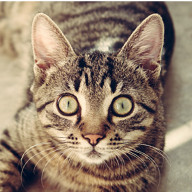

In [ ]:
from PIL import Image

cat_in_pil = Image.open("cat.jpg")
display(cat_in_pil)

Изображение из формата Pillow надо превратить в `torch.Tensor`:

In [ ]:
cat_in_np = np.array(cat_in_pil)  # pillow -> numpy
cat_in_float = cat_in_np.astype(np.float32) / 255  # int->float
cat_in_tensor = torch.tensor(cat_in_float)  # np -> torch

try:
    conv_ch3(cat_in_tensor.unsqueeze(0))  # add batch dimension
except Exception as e:
    print("Error: \n", e)

Error: 
 Given groups=1, weight of size [1, 3, 5, 5], expected input[1, 192, 192, 3] to have 3 channels, but got 192 channels instead


Получили ошибку, связанную с количеством каналов. Дело в том, что в PyTorch, в отличие от OpenCV, TensorFlow и ряда других библиотек, каналы (RGB) идут в первом, а не в последнем измерении тензора, описывающего картинку.

OpenCV, TensorFlow, Pillow, etc. : $[\text{Batch}, \text{Height}, \text{Width}, \text{Channels}]$

PyTorch : $[\text{Batch}, \text{Channels}, \text{Height}, \text{Width}]$

Придется сделать дополнительное преобразование, чтобы каналы оказались на том месте, где их ожидает PyTorch:

In [ ]:
print("Original \t", cat_in_tensor.shape, "HWC")
cat_in_tensor_channel_first = cat_in_tensor.permute(2, 0, 1)  # HWC -> CHW
print("Torch style \t", cat_in_tensor_channel_first.shape, "CHW")

Original 	 torch.Size([192, 192, 3]) HWC
Torch style 	 torch.Size([3, 192, 192]) CHW


Теперь можно подать изображение на вход модели, предварительно добавив batch-размерность:

In [ ]:
one_image_batch = cat_in_tensor_channel_first.unsqueeze(0)  # HW -> CHW, C = 1
out = conv_ch3(one_image_batch)
print("No error!")

No error!


Нет необходимости проделывать все эти манипуляции вручную, так как в torchvision реализованы класс `ToTensor` [🛠️[doc]](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html?highlight=totensor#torchvision.transforms.ToTensor) и функция `to_tensor` [🛠️[doc]](https://pytorch.org/vision/main/generated/torchvision.transforms.functional.to_tensor.html), которые выполняют эти преобразования.

Убедимся, что тензор, преобразованный нами вручную, и тензор, получившийся после применения функции `to_tensor`, совпали:

In [ ]:
from torchvision.transforms.v2.functional import to_tensor

cat_in_tensor2 = to_tensor(cat_in_pil)  # auto HWC -> CHW
print(cat_in_tensor2.shape)

print(
    "Tensor almost equal: ",
    torch.allclose(cat_in_tensor_channel_first, cat_in_tensor2),  # float comparsion
)

torch.Size([3, 192, 192])
Tensor almost equal:  True


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/functional/_deprecated.py:12: UserWarning: The function `to_tensor(...)` is deprecated and will be removed in a future release. Instead, please use `to_image(...)` followed by `to_dtype(..., dtype=torch.float32, scale=True)`.
  warnings.warn(


Теперь посмотрим на форму выхода, полученного нами ячейкой выше:

In [ ]:
print("Output feature map size:", out.shape)  # first dim is batch

Output feature map size: torch.Size([1, 1, 188, 188])


Такую размерность имеет выход  **единственного нейрона** в нашем сверточном слое.

На входе несколько каналов (3), на выходе остался один канал.
Как же комбинируются результаты сверток в разных каналах?



<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/convolution_rgb.png" width="700">


Результаты сверток всех ядер фильтра с соответствующими входными каналами просто суммируются:

$\large \displaystyle \text{feature_map}(x,y) = \sum_{c}^{C} \sum_{i}^{H} \sum_{j}^{W}k_c[i,j]I_c[x+j,y+i] + \text{bias},$

$C$ — количество каналов,

$H, W$ — высота и ширина ядра фильтра,

$K_c$ — ядро для канала $c$,

$I$ — изображение (массив $С\times H\times W$),

$I_c$ — канал изображения номер $c$ (срез массива $I$, соответствующий каналу изображения номер $c$).

В силу коммутативности суммы не важно, в каком порядке будут складываться элементы. Можно считать, что каждый элемент входа сначала умножается на свой коэффициент из ядра, а уже затем все суммируется.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/rgb_image_convolution_filter.png" width = "650">

Так выглядит выход одного нейрона, который задается несколькими ядрами и  смещением (bias).

При этом bias  **один** на весь фильтр.

In [ ]:
print("Kernels", conv_ch3.weight.shape)
print("Biases", conv_ch3.bias.shape)

Kernels torch.Size([1, 3, 5, 5])
Biases torch.Size([1])


Входные данные не всегда будут трехканальными цветными [RGB 📚[wiki]](https://ru.wikipedia.org/wiki/RGB)-изображениями, в которых цвет пикселя определяется тремя числами, характеризующими три основных цвета (красный, зеленый и синий).

Входной тензор может иметь произвольное количество каналов. Например: марсоход Opportunity для получения изображений использовал [13 каналов ✏️[blog]](https://habr.com/ru/post/160621/).

Более того, в качестве входного тензора можно использовать не входное изображение, а **карту признаков (feature map)** с выхода предыдущего сверточного слоя.


## Использование нескольких фильтров

Возвращаемся ко второму параметру конструктора `nn.Conv2D` —
`out_channels = 1`. Этот параметр задает количество фильтров слоя. То есть количество выходных карт признаков всегда совпадает с `out_channels` сверточного слоя.

In [ ]:
conv35 = Conv2d(in_channels=3, out_channels=5, kernel_size=3)
out = conv35(cat_in_tensor_channel_first)

print(f"weights shape: {conv35.weight.shape}")  # 5 filters 3x3x3
print(f"weights shape: {conv35.bias.shape}")  # one bias per filter

weights shape: torch.Size([5, 3, 3, 3])
weights shape: torch.Size([5])


В линейном слое каждый нейрон учился активироваться на некий шаблон, например, красную машину или смотрящую направо лошадь.

Мы хотим, чтобы нейроны сверточного слоя также активировались на различные паттерны (например, ухо, нос, глаз и т.д.). Для каждого паттерна нам нужен свой нейрон $⇒$ свой фильтр.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/neuron_is_filter.png" width="700">

 Каждый нейрон сформирует свою карту признаков размера $1\times H_{out}\times W_{out}$. А на выходе слоя будет их конкатенация:

In [ ]:
print(f"result shape: {out.shape}")  # 5 feature map

result shape: torch.Size([5, 190, 190])


При объединении этих карт получится тензор размерности $C_{out}\times H_{out} \times W_{out}$, где $C_{out}$ — количество фильтров.



На изображении ниже продемонстрирован результат применения сверточного слоя,
содержащего $5$ фильтров, к изображению из CIFAR-10.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/convolution_layer_with_5_filters.png" width="400">

Стоит отметить, что, в отличие от полносвязного слоя, свёрточный слой не требует информации о количестве значений во входном представлении и может быть использован как для представлений $C_{in} \times 32 \times 32$, так и для $C_{in} \times 100 \times 100$. Словом, представления могут иметь практически любой размер, главное, чтобы пространственные размеры не были меньше размеров ядра свёртки.



## Уменьшение размера карты признаков

Карта признаков после применения функции активации может быть передана на вход следующей операции свёртки.

In [ ]:
from torch.nn.functional import relu

conv_1 = torch.nn.Conv2d(
    in_channels=3,  # Number of input channels (3 for RGB images)
    out_channels=6,  # Number of filters/output channels
    kernel_size=5,
)

conv_2 = torch.nn.Conv2d(
    in_channels=6,  # Number of input channels (3 for RGB images)
    out_channels=10,  # Number of filters/output channels
    kernel_size=5,
)

img = torch.randn((1, 3, 32, 32))  # 1-batch size, 3-num of channels, (32,32)-img size
print(f"img shape: {img.shape}")

out_1 = conv_1(img)
print(f"out_1 shape: {out_1.shape}")  # [1, 6, 28, 28]

out_2 = conv_2(relu(out_1))
print(f"out_2 shape: {out_2.shape}")  # [1, 10, 24, 24]

img shape: torch.Size([1, 3, 32, 32])
out_1 shape: torch.Size([1, 6, 28, 28])
out_2 shape: torch.Size([1, 10, 24, 24])


Заметим, что после свёртки ширина $W_{out}$ и высота $H_{out}$ **карты признаков** будут отличаться от **пространственных размерностей** $W_{in}$ и $H_{in}$ исходного тензора. К примеру, при обработке трёхканального тензора размера $32\times32$ ядром размера $5\times5$ можно будет произвести лишь $27$ сдвигов $(32 - 5)$ по вертикали и столько же по горизонтали. Но при этом размер итоговой карты признаков будет равен $28 \times 28$, поскольку первый ряд (либо столбец) можно получить без сдвигов по вертикали либо горизонтали соответственно. При повторном применении фильтра размер каждой из сторон уменьшится ещё на $4$.

Итоговое значение $N'$ пространственной размерности $N$ для квадратного фильтра $K \times K$ фильтра $F$ вычисляется по следующей формуле:
$$\large N' = N - K + 1$$.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/decrease_size_of_image_after_convolution.png" width="700">

Заметим, что при уменьшении размера представлений пиксели, находящиеся около краёв, участвуют в значительно меньшем количестве свёрток, чем пиксели в середине, хотя информация в них не обязательно менее ценна, чем информация из центральных пикселей. К примеру, пиксель в верхнем левом углу представления вне зависимости от размера фильтра будет принимать участие лишь в одной свёртке, и информация о нём будет сохранена лишь в верхнем левом углу нового представления.

## Расширение (padding)

Для борьбы с описанной выше проблемой применяется *набивка/дополнение* входного тензора (англ. *padding*). В ходе него ширина и высота тензора увеличиваются за счёт приписывания столбцов и строк с некоторыми значениями. К примеру, на изображении ниже перед свёрткой ядром размера $3\times3$ был применён padding нулями.

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/padding.png" width="250">

На примере убедимся, что это позволит нам сохранить пространственные размерности тензоров.

In [ ]:
img = torch.randn((1, 1, 5, 5))  # create random image BCHW
print(f"Original tensor:\nshape:{img.shape}")
conv_3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conved_3 = conv_3(img)
print("Shape after convolution layer(kernel 3x3):", conved_3.shape)

Original tensor:
shape:torch.Size([1, 1, 5, 5])
Shape after convolution layer(kernel 3x3): torch.Size([1, 1, 3, 3])


Карта признаков меньше, чем вход. Теперь добавим padding:

In [ ]:
# add zeros to image manually
padded_img = torch.zeros((1, 1, 7, 7))  # create zeros array to insert image in center
padded_img[:, :, 1:-1, 1:-1] += img  # insert image, we get image arounded by zeros
print(f"\nPadded tensor:\nshape:{padded_img.shape}:\n {padded_img}")

conved_pad_3 = conv_3(padded_img)
print("\n\nPadded shape:", padded_img.shape)
print("Shape after convolution with padding(kernel 3x3):", conved_pad_3.shape)


Padded tensor:
shape:torch.Size([1, 1, 7, 7]):
 tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.5402, -2.4546,  0.3934, -0.0685, -0.8054,  0.0000],
          [ 0.0000, -0.2551,  0.7050,  0.1064,  0.3913,  0.0630,  0.0000],
          [ 0.0000,  0.5743,  0.4731, -0.7941,  0.8732,  0.0313,  0.0000],
          [ 0.0000,  0.9114, -0.1068,  0.6257, -1.0923, -0.9405,  0.0000],
          [ 0.0000, -0.4192,  0.4200, -0.9414, -0.5007, -2.3843,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]]])


Padded shape: torch.Size([1, 1, 7, 7])
Shape after convolution with padding(kernel 3x3): torch.Size([1, 1, 5, 5])


Размер выхода равен размеру входа.

Однако если мы увеличим размер ядра до $5\times5$, то увидим, что, несмотря на padding, выход снова стал меньше входа:

In [ ]:
conv_5 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=5)

conved_pad_5 = conv_5(padded_img)

print("Original shape:", img.shape)
print("Shape after convolution with padding(kernel 5x5):", conved_pad_5.shape)

Original shape: torch.Size([1, 1, 5, 5])
Shape after convolution with padding(kernel 5x5): torch.Size([1, 1, 3, 3])


Дополнение одним рядом и одним столбцом не является универсальным решением: для фильтра размером $5$ размер выходного тензора всё равно отличается от входного. Если мы немного видоизменим полученную выше формулу (используя размер дополнения $P$), то получим:
$$\large N' = N + 2\cdot P - K + 1$$

Для того, чтобы пространственные размеры не изменялись ($N' = N$), для разных размеров фильтра требуются разные размеры дополнения. В общем случае для размера фильтра $F$ требуемый размер дополнения:
$$\large P = \frac{K-1}{2}$$




Теперь реализуем padding, используя инструменты библиотеки PyTorch, и сравним его с ручным добавлением padding:

In [ ]:
# conv layer without padding (padding=0 by default)
conv_3 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=0)

# conv layer with padding = 1 (add zeros)
conv_3_padded = torch.nn.Conv2d(
    in_channels=1, out_channels=1, kernel_size=3, padding=1
)  # Padding added 1 zeros line to all four sides of the input
original = conv_3(padded_img)
padded = conv_3_padded(img)

print(f"Explicitly padded:\n{original.shape}")
print(f"\nImplicitly padded:\n{padded.shape}")

Explicitly padded:
torch.Size([1, 1, 5, 5])

Implicitly padded:
torch.Size([1, 1, 5, 5])


Кроме чисел параметр `padding` может принимать значение `"same"` — тогда padding будет рассчитан автоматически так, чтобы размер выходного тензора не отличался от размера входного тензора, или `"valid"` — отсутствие дополнения.

По умолчанию `padding = 0`, а если его изменить на целочисленное значение, то края тензора будут дополняться нулями, как в примерах выше. Это тоже не универсальный способ обработки краев изображения при свертках. Есть модификации: например, в `numpy.pad` [🛠️[doc]](https://numpy.org/doc/stable/reference/generated/numpy.pad.html) есть зеркальный padding или заполнение средним значением.

Визуализация работы свертки:

<img src ="https://ml.gan4x4.ru/msu/dev-2.2/L06/out/convolution_with_same_padding_rgb_image.gif" width="780">

# Batchnorm 2d

Сверточный слой можно свести к линейному слою. BatchNorm можно применять и для линейных слоев, и для сверточных.

Признаки внутри одного канала (одной карты признаков) получаются путем применения к исходному изображению одних и тех же преобразований. По сути **1 канал** — это **карта одного признака**. Поэтому логично, что нормализация будет происходить по каналам, а одним признаком считается одна **feature map**.
Нормализация идет по всей такой feature map (по всему каналу) для всех объектов батча.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/feature_map.png" width="500"></center>

В PyTorch для полносвязных слоев используют `nn.BatchNorm1d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), а для сверточных — `nn.BatchNorm2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html).

Графически нормализации часто объясняют при помощи следующей схемы:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dimensions_channels_batch_samples.png" width="450"></center>

*По оси абсцисс* расположены **объекты из батча**,
*по оси ординат* &mdash; **feature map**, преобразованный в вектор,
*по оси аппликат* &mdash; **каналы** (feature maps).

Размер такого кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

В этом представлении **BatchNorm** для свертки выглядит следующим образом:

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/visualization_of_batch_normalization.png" width="450">

<em>Source: <a href="https://paperswithcode.com/method/batch-normalization">Batch Normalization</a></em></center>

Статистки считаются по срезу:

$$[\text{:}, \text{ channels}, \text{ :}, \text{ :}]$$

Всего считается $\text{channels}$ статистик, по одной для каждой карты признаков.

## Другие Normalization

Существует большое количество иных нормализаций, их неполный список можно найти [здесь 🎓[article]](https://paperswithcode.com/methods/category/normalization). В данной секции мы рассмотрим самые популярные виды нормализации помимо **BatchNorm**.


Есть несколько мотиваций для замены батч-нормализации на другие типы нормализации:
- при обучении модели вы можете столкнуться с ситуацией, когда вам нужно учить модель при `batch_size=1` (больше не помещается на видеокарту). BN работает неэффективно с маленькими размерами батча,
- при параллельном обучении модели на нескольких видеокартах необходимо обмениваться статистиками для BN между устройствами. Обмен информацией между устройствами может замедлять обучение.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.1/L07/normalization_methods.png" width="900">

<em>Source: <a href="https://paperswithcode.com/method/layer-normalization">Layer Normalization</a></em></center>

### Layer Norm

Помимо свёрточных нейронных сетей, существует специальный тип нейронных сетей, используемых для обработки последовательностей. Называется он "**рекуррентные нейронные сети**".

Когда оказалось, что **BatchNorm** положительно сказывается на обучении нейронных сетей, его попытались применить для различных архитектур. BatchNorm нельзя было использовать "из коробки" для рекуррентных нейронных сетей (работающих с последовательными данными), пришлось придумывать различные адаптации, среди которых наиболее удачной оказалась **Layer Normalization**.

По сути, теперь нормализация происходит внутри **одного объекта из батча**, а не поканально в рамках батча. С математической точки зрения данная "адаптация" отличается от **BatchNorm**, однако экспериментально она превзошла своих конкурентов в задаче нормализации при обработке последовательных данных.

Впоследствии данный метод нормализации хорошо проявил себя в **трансформерах** — наследниках рекуррентных нейронных сетей в вопросах обработки последовательных данных. После успешного применения трансформеров в задачах компьютерного зрения, **LayerNorm** стал использоваться и в компьютерном зрении.

Размер кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

Статистики считаются по срезу:
$$[\text{batch size}, \text{ :}, \text{ :}, \text{ :}]$$

По одной статистике для кажого объекта в батче.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/visualization_of_layer_normalization.png" width="450">

<em>Source: <a href="https://paperswithcode.com/method/layer-normalization">Layer Normalization</a></em></center>


### Instance Norm

Следующий вид нормализации был предложен отечественными исследователями (из Сколтеха), занимавшимися разработкой быстрого и эффективного способа **переноса стиля** с одного изображения на другое.

При использовании BatchNorm теряется информация о контрастах на конкретном изображении, поскольку нормализация производится по нескольким объектам. Для сохранения *контрастов* в экземпляре (*instance*) изображения была предложена специальная нормализация, рассматривающая конкретный канал одного конкретного объекта. Было предложено два названия нормализации: связанное с мотивацией (contrast normalization) и связанное с принципом работы (**instance normalization**).

Размер кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

Статистики считаются по срезу:
$$[\text{batch size}, \text{channels}, \text{ :}, \text{ :}]$$

По одной статистике для каждого канала каждого объекта в батче.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/visualization_of_instance_normalization.png" width="450"></center>

<center><em>Source: <a href="https://paperswithcode.com/method/instance-normalization">Instance Normalization</a></em></center>

### Group Norm

В течение долгого времени BatchNorm оставался однозначным фаворитом для использования в задачах компьютерного зрения, однако:
1. В связи с необходимостью точно считать статистики внутри batch при обучении приходилось использовать большой batch size.

2. Ограниченность размера памяти видеокарты вынуждает разработчиков идти на компромисс между сложностью модели и размером батча.

Таким образом, использование BatchNorm приводило к невозможности использовать сложные модели**\***, поскольку им просто не хватало места на видеокарте.

Необходимость использовать большой batch size могут решать различные нормализации, не использующие batch-размерность. К примеру, уже известные нам **Layer Norm** и **Instance Norm**. Эмпирически оказалось, что данные нормализации уступают BatchNorm по качеству работы: в то время как LayerNorm предполагает одинаковую важность и суть различных каналов (*рассматривая данные излишне глобально*), InstanceNorm упускает межканальные взаимодействия (*рассматривая данные слишком локально*).

Успешным обобщением данных методов является **Group Normalization**: данный метод разбивает каналы на $G \in [1; C]$ групп, присваивая каждой из них примерно равное количество каналов. Отметим, что при $G = 1$ GroupNorm идентичен LayerNorm, а при $G = C$ GroupNorm идентичен InstanceNorm.

Эмпирически оказалось, что при замене BatchNorm на GroupNorm качество модели падает в разы менее значительно, чем при использовании LayerNorm либо InstanceNorm. Более того, при изменении batch size качество работы GroupNorm не изменялось, что открыло перспективы для создания более сложных моделей компьютерного зрения.

**\*** — подразумевается, что уменьшение batch size позволило бы создать более сложные модели.

Размер кубика:
$$[\text{batch size}, \text{channels}, \text{h}, \text{w}]$$

Статистики считаются по срезу:
$$[\text{batch size}, \text{ i: j}, \text{ :}, \text{ :}]$$

По одной статистике для каждой группы каналов каждого объекта в батче.

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/visualization_of_group_normalization.png" width="450"></center>

<center><em>Source: <a href="https://paperswithcode.com/method/group-normalization">Group Normalization</a></em></center>

# Dropout 2d

Аналогично **Batch Normalization**, при применении к **сверточному слою**  **Dropout** должен **убирать каналы целиком**. Dropout для полносвязного слоя реализован в PyTorch в `nn.Dropout` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html), для сверточного — в `nn.Dropout2d` [🛠️[doc]](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html).

<center><img src ="https://ml.gan4x4.ru/msu/dev-2.2/L07/out/dropout_2d.png" width="700"></center>